Welcome to spinqick!

In [1]:
import Pyro4
from qick import QickConfig
from spinqick.models import config_models, hardware_config_models
from spinqick.helper_functions import file_manager
from spinqick.experiments import system_calibrations

%matplotlib widget

First we can connect to our qick board.  We use a pyro server to communicate with our board, which allows us to run python code on our computer instead of on the small cpu provided on the board.

In [3]:
Pyro4.config.SERIALIZER = "pickle"
Pyro4.config.PICKLE_PROTOCOL_VERSION = 4

ns_host = "192.168.3.99"  # make sure this matches your board's ip address!
ns_port = 8888
proxy_name = "myqick"

ns = Pyro4.locateNS(host=ns_host, port=ns_port)
soc = Pyro4.Proxy(ns.lookup(proxy_name))
soccfg = QickConfig(soc.get_cfg())
print(soccfg)


QICK configuration:

	Board: ZCU216

	Software version: 0.2.261
	Firmware timestamp: Mon Apr 22 09:28:53 2024

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (9.524 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 32-bit DDS, range=6881.280 MHz
		DAC tile 2, blk 0 is 0_230, on JHC3
	1:	axis_signal_gen_v6 - envelope memory 65536 samples (9.524 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 32-bit DDS, range=6881.280 MHz
		DAC tile 2, blk 1 is 1_230, on JHC4
	2:	axis_signal_gen_v6 - envelope memory 65536 samples (9.524 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 32-bit DDS, range=6881.280 MHz
		DAC tile 2, blk 2 is 2_230, on JHC3
	3:	axis_signal_gen_v6 - envelope memory 65536 samples (9.524 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 32-bit DDS, range=6881.280 MHz
		DAC tile 2, blk 3 is 3_230, on JHC4
	4:	axis_signal_gen_v6 - envelope memory 65536 samples (9.524 us)
		fs=6881.280 MHz, fabric=430.08

Dot experiments can be complex and require us to store and organize many parameters for every experiment.  Most of the parameters used in spinqick are passed into the experiment code using a dictionary which we call a config. Some parameters in the config are shared across many experiments, for example the setup of readout parameters like source-drain chop amplitude. We store these parameters in dictionaries which are saved to yaml files, with filepaths specified in spinqick.settings.filesettings.

In spinqick.models we've made templates for hardware and readout config files, so we can use those to create some example configs now.  We start with the hardware config, which is a hardware map describing all of the low-speed and high-speed lines connecting to each gate.


In [4]:
readout_in = hardware_config_models.SourceDrainIn(qick_gen=0)
readout_out = hardware_config_models.SourceDrainOut(qick_adc=0)
gate_a = hardware_config_models.FastGate(
    dc_conversion_factor=4,
    slow_dac_address="slow_dac_address",
    slow_dac_channel=0,
    crosscoupling=None,
    dac_conversion_factor=10000,
    qick_gen=1,
)
gate_b = hardware_config_models.SlowGate(
    dc_conversion_factor=4,
    slow_dac_address="slow_dac_address",
    slow_dac_channel=1,
    crosscoupling=None,
)

hardware = hardware_config_models.HardwareConfig(
    SD_in=readout_in,
    SD_out=readout_out,
    channels={"A": gate_a, "B": gate_b},
    voltage_source="slow_dac",
)

hw_cfg = hardware.model_dump()

file_manager.save_config(hw_cfg, "C:/Data/dummy/hardware_cfg.yaml")
# here's the dict we just made
hw_cfg

{'SD_in': {'qick_gen': 0},
 'SD_out': {'qick_adc': 0},
 'channels': {'A': {'dc_conversion_factor': 4.0,
   'slow_dac_address': 'slow_dac_address',
   'slow_dac_channel': 0,
   'crosscoupling': None,
   'dac_conversion_factor': 10000.0,
   'qick_gen': 1},
  'B': {'dc_conversion_factor': 4.0,
   'slow_dac_address': 'slow_dac_address',
   'slow_dac_channel': 1,
   'crosscoupling': None}},
 'voltage_source': 'slow_dac'}

Next we store information in the readout config dictionary. This dictionary holds some frequently used readout parameters, and every spinqick function uses the readout config. To get started we only need the DCS_cfg part.

In [5]:
readout = config_models.ReadoutConfig(
    DCS_cfg=config_models.DcsConfig(
        adc_trig_offset=0,
        dds_freq=1,
        readout_freq=1,
        length=soccfg.us2cycles(1),
        readout_length=soccfg.us2cycles(1),
        pulse_gain_readout=1000,
        res_ch=0,
        ro_ch=0,
    ),
    PSB_cfg=None,
)

readout_cfg = readout.model_dump()
readout_cfg = file_manager.sync_configs(
    readout_cfg=readout_cfg, hardware_cfg=hw_cfg
)  # copies res_ch and ro_ch parameters from hardware config to make sure they are the same
file_manager.save_config(readout_cfg, "C:/Data/dummy/readout_cfg.yaml")
readout_cfg

{'DCS_cfg': {'adc_trig_offset': 0,
  'dds_freq': 1.0,
  'readout_freq': 1.0,
  'length': 430,
  'readout_length': 430,
  'pulse_gain_readout': 1000,
  'res_ch': 0,
  'ro_ch': 0},
 'PSB_cfg': None}

Now we're ready to try running an experiment.  We will load a simple experiment from the system_calibrations module. This experiment just sweeps a single parameter called 'adc_trig_offset' which is the delay between when the dac outputs a pulse and when the adc begins to collect data.

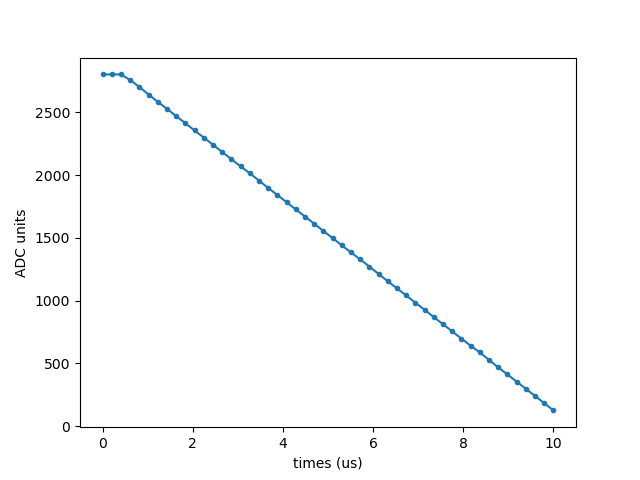

In [9]:
# initialize experiment class
cal_exp = system_calibrations.SystemCalibrations(soccfg, soc, init_slow_dac=False)
# run experiment
times, amplitudes = cal_exp.sweep_adc_trig_offset(times=(0, 10, 50), avgs=10)

TODO fill in the rest of this notebook!
